# Table of Contents
 <p>

In [1]:
# ------------------------------------------------------------------------------
# Set training variables
# ------------------------------------------------------------------------------

# System level
import sys

# Future functions
from __future__ import print_function

# Arrays
import numpy as np

# Keras (www.keras.io)
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

# Sklearn (for machine learning)
from sklearn import metrics

# Plots
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
try:
    import seaborn as sns
except:
    pass

# to do:
# save data structure to new file
# test

# theano
import theano
#print "CONFIG:", theano.config.device

Using Theano backend.
Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 65.0% of memory, cuDNN 5005)


In [2]:
# ------------------------------------------------------------------------------
# Set variables
# ------------------------------------------------------------------------------

# training variables
nb_train = 5000  # number of objects for training (of both classes)
nb_valid = 2000  # ... validation
nb_test = 2000   # ... test
nb_epoch = 10    # number of passes over full neural network during training
nb_classes = 2   # number of classes (i.e., lens or non-lens)
batch_size = 32 # number objects to put in memory at once 

# data location
dir_test = "/Users/nord/Dropbox/deeplensing/Data/Simulation/SimLensPop/Data161/"

In [3]:
# ------------------------------------------------------------------------------
# Read in Data
# ------------------------------------------------------------------------------

# set file names for data
file_x_data = dir_test + "xtrain_lenspop.npy" # x data (images)
file_y_data = dir_test + "ytrain_lenspop.npy" # y data (labels)
#file_lens_data = dir_test + "lenspars_set.npy" # lens data (physical parameters of lenses/non-lenses)
file_ids_data = dir_test + "itrain_lenspop.npy"
f_model = dir_test + "model.json" # model data (architecture)
f_weights = dir_test + "weights.h5" # model data (weights that we fit for)

# load data
x_data = np.load(file_x_data)
y_data = np.load(file_y_data)
#lens_data = np.load(file_lens_data)
ids_data = np.load(file_ids_data)

# check data sizes
statement =  "#TrainingSamples + #ValidSamples #TestSamples > TotalSamples, exiting!!!"
nb_total = nb_train + nb_test + nb_valid
assert nb_total <= len(x_data), statement

# indices for where to slice the arrays
ind_valid_start = ind_train_end = nb_train
ind_valid_end = ind_test_start = nb_train + nb_valid
ind_test_end = nb_train + nb_valid + nb_test

# slice the image arrays
x_train = x_data[:ind_train_end, :, :, :]
x_valid = x_data[ind_valid_start: ind_valid_end, :, :, :]
x_test = x_data[ind_test_start: ind_test_end, :, :, :]

# slice the label arrays
y_train = y_data[:ind_train_end]
y_valid = y_data[ind_valid_start: ind_valid_end]
y_test = y_data[ind_test_start: ind_test_end]

# slice lens data
#lens_test = lens_data[ind_test_start: ind_test_end]
ids_test = ids_data[ind_test_start: ind_test_end]

# cast data types
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

print("Data dimensions: ")
print("Input data: \t ", np.shape(x_data), np.shape(y_data))
print("Training set: \t ", np.shape(x_train), np.shape(y_train))
print("Validation set:  ", np.shape(x_valid), np.shape(y_valid))
print("Test Set:   \t ", np.shape(x_test), np.shape(y_test))

Data dimensions: 
Input data: 	  (50000, 3, 64, 64) (50000,)
Training set: 	  (5000, 3, 64, 64) (5000,)
Validation set:   (2000, 3, 64, 64) (2000,)
Test Set:   	  (2000, 3, 64, 64) (2000,)


In [5]:
# ------------------------------------------------------------------------------
# Set up model architecture
# ------------------------------------------------------------------------------

# Define architecture for model
data_shape = np.shape(x_data)
input_shape = (3, 64, 64)
x = Input(shape=input_shape)
c0 = Convolution2D(32, 3, 3, activation='softplus', subsample=(4, 4), border_mode='same', dim_ordering='th')(x)
b0 = BatchNormalization()(c0)
d0 = Dropout(0.5)(b0)
c1 = Convolution2D( 8, 3, 3, activation='softplus', subsample=(2, 2), border_mode='same')(d0)
b1 = BatchNormalization()(c1)
d1 = Dropout(0.5)(b1)
f = Flatten()(d1)
z0 = Dense(128, activation='softplus')(f)
z1 = Dense(32, activation='softplus')(z0)
y = Dense(1, activation='sigmoid')(z1)
model = Model(input=x, output=y)

# Compile Model
optimizer = 'adadelta'
metrics_model = ['accuracy']
loss = 'binary_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=metrics_model)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 64, 64)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 16, 16)    896         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 32, 16, 16)    64          convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 16, 16)    0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [6]:
# ------------------------------------------------------------------------------
# Train model (using 'train' and 'valid' data)
# ------------------------------------------------------------------------------

# Train 
history = model.fit(
                    x_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=nb_epoch,
                    validation_data=(x_valid, y_valid),
                    verbose=True
                    )
# Save data
model.save_weights(f_weights, overwrite=True)
open(f_model, 'w').write(model.to_json())

Train on 5000 samples, validate on 2000 samples
Epoch 1/10
5000/5000 [==============================] - 4s - loss: 0.6175 - acc: 0.6484 - val_loss: 0.8542 - val_acc: 0.4995

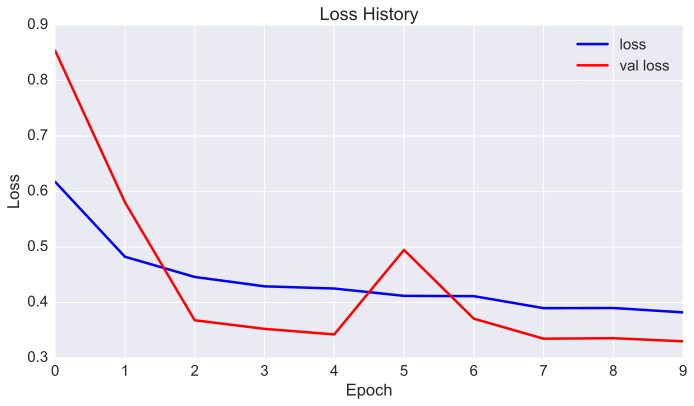

In [10]:
# ------------------------------------------------------------------------------
# Plot: Loss History during Training and Receiver-Operator Curve (ROC)
# ------------------------------------------------------------------------------

try:
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
except: 
    pass
hist = history.history
loss = hist['loss']
val_loss = hist["val_loss"]
epochs = np.arange(nb_epoch)
fig, axis1 = plt.subplots(figsize=(10,6))
plt.plot(epochs, loss, 'b', label='loss')
plt.plot(epochs, val_loss, 'r', label="val loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss History")
plt.legend(loc='upper right')
plt.tight_layout()

In [20]:
# ------------------------------------------------------------------------------
# Evaluate (using 'test' data)
# ------------------------------------------------------------------------------

# predict on 'test'
y_prob = model.predict(x_test) # probability of being a lens
y_pred = (y_prob > 0.5).astype('int32') # binary classification

# measure confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])
cm = cm.astype('float')
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
print("True Positive (rate): ", cm[1,1], "({0:0.4f})".format(cm_norm[1,1]))
print("True Negative (rate): ", cm[0,0], "({0:0.4f})".format(cm_norm[0,0]))
print("False Positive (rate):", cm[1,0], "({0:0.4f})".format(cm_norm[1,0]))
print("False Negative (rate):", cm[0,1], "({0:0.4f})".format(cm_norm[0,1]))

# measure receiver-operator curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob, pos_label=1)

# measure Area Under Curve (AUC)
auc = metrics.roc_auc_score(y_test, y_prob)
print()
print("AUC:", auc)

True Positive (rate):  767.0 (0.7763)
True Negative (rate):  972.0 (0.9605)
False Positive (rate): 221.0 (0.2237)
False Negative (rate): 40.0 (0.0395)

AUC: 0.938753180458


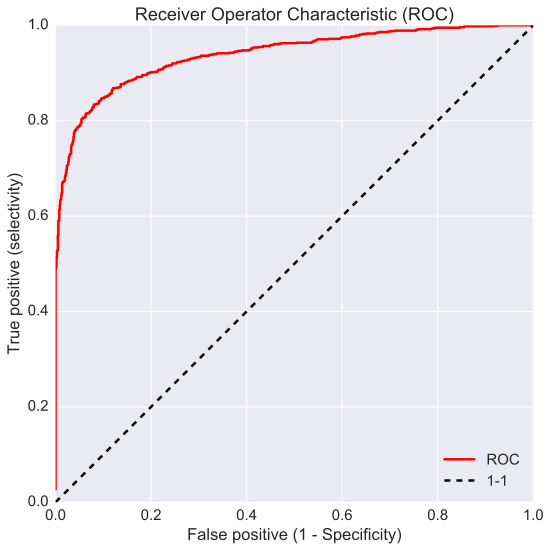

In [12]:
# ------------------------------------------------------------------------------
# Plot: Receiver-Operator Curve (ROC)
# ------------------------------------------------------------------------------

fig, axis1 = plt.subplots(figsize=(8,8))
plt.plot(fpr, tpr, 'r-', label='ROC')
plt.plot([0,1], [0,1], 'k--', label="1-1")
plt.title("Receiver Operator Characteristic (ROC)")
plt.xlabel("False positive (1 - Specificity)")
plt.ylabel("True positive (selectivity)")
plt.legend(loc='lower right')
plt.tight_layout()

In [34]:
# ------------------------------------------------------------------------------
# Plot: Image Grid
# ------------------------------------------------------------------------------

# Remove tick labels on images
def remove_tick_info(axis):
    """Remove tick labels."""

    axis.set_xticklabels([])
    axis.set_yticklabels([])

    for tl in axis.xaxis.get_major_ticks():
        tl.tick1On = tl.tick2On = False
    for tl in axis.yaxis.get_major_ticks():
        tl.tick1On = tl.tick2On = False

    return


# Plot grid of images
def plot_grid_images(file_list, n_grid_x, n_grid_y, dpi=400, figsize=(10,4.5)):
    """Plot a grid of images."""

    # create figure
    fig = plt.figure(0, figsize=figsize)

    # create grid
    gs = gridspec.GridSpec(n_grid_y, n_grid_x, hspace=0, wspace=0)
    
    # create list of axes for grid
    axis_list = []
    for i in range(n_grid_y):
        for j in range(n_grid_x):
            axis_temp = fig.add_subplot(gs[i, j])
            axis_list.append(axis_temp)

    # loop over files and axes (fill)
    ind_axis_count = 0
    for fil, axis in zip(file_list, axis_list):

        # read image
        image = mpimg.imread(fil)

        # plot image
        axis.imshow(image, aspect='equal', alpha=1, origin=None)

        # remove grid
        axis.grid(False)
        
        # remove tick info
        remove_tick_info(axis)

        ind_axis_count += 1

        # clean up empty cells in grid
        for ind_axis in range(ind_axis_count, len(axis_list)):
            axis_temp = axis_list[ind_axis]
            remove_tick_info(axis_temp)
            axis_temp.grid(False)
            axis_temp.axis('off')

            
def create_file_list(ids_select, lens_class):
    # name directories
    dicts_class = {"0": "nons", "1": "lens"}
    dir_image = dir_test + "class_" + lens_class + "_"+dicts_class[lens_class]+ "/"

    file_list= []
    for image_id in ids_select:
        file_name= dir_image + "img_class_" + lens_class + "_"+dicts_class[lens_class]+"_" + str(image_id).zfill(5) + ".png"

        file_list.append(file_name)

    file_list= np.array(file_list)
    
    return file_list

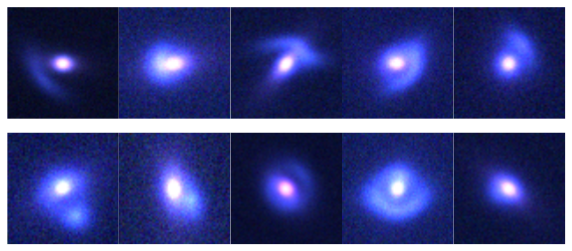

In [36]:
# ------------------------------------------------------------------------------
# Select systems by their classification status: True positive
# ------------------------------------------------------------------------------

# select true positives
inds_logical = np.logical_and(y_pred[:,0] == 1., y_test == 0.)
inds = np.where(inds_logical==True)[0]

lens_class = "1"
ids_select = ids_test[inds]

file_list = create_file_list(ids_select, lens_class)


plot_grid_images(file_list[0:10], 5, 2)

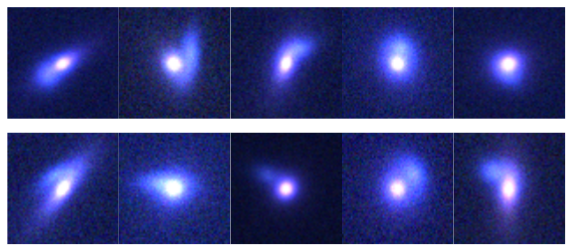

In [37]:
# ------------------------------------------------------------------------------
# Select systems by their classification status: False positive
# ------------------------------------------------------------------------------

# select true positives
inds_logical = np.logical_and(y_pred[:,0] == 1., y_test == 0.)
inds = np.where(inds_logical==True)[0]

lens_class = "0"
ids_select = ids_test[inds]

file_list = create_file_list(ids_select, lens_class)


plot_grid_images(file_list[0:10], 5, 2)